# Flare-Up Prediction Models (RF + NN + XGBoost)

In [ ]:
# Install dependencies (Colab)
!pip install xgboost

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import joblib

df = pd.read_csv('allergydf.csv')
df.head()

,user_id,date,season,temperature,humidity,dust_level,smoke_level,outdoor_time_min,medication_used,symptom_score,flare_up
0,user_2,2023-11-09,rainy_late,23.698531,77.226450,22.654872,13.828442,60.500841,1,1,0
1,user_12,2023-11-21,rainy_late,33.646917,73.180224,12.559737,35.166510,83.940761,0,1,1
2,user_2,2023-12-08,dry,27.908462,72.976011,27.472139,22.347591,0.000000,0,1,1
3,user_19,2023-06-29,rainy_peak,23.155849,78.412614,9.097156,19.302795,49.542227,1,1,0
4,user_8,2023-06-23,rainy_peak,15.914323,75.607445,0.609801,1.236706,58.015698,0,1,1


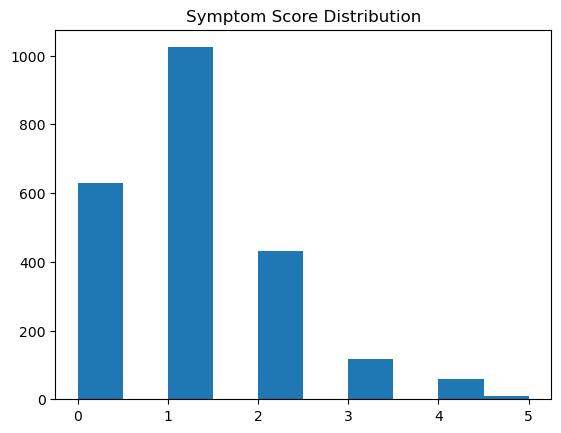

In [4]:
plt.hist(df["symptom_score"])
plt.title("Symptom Score Distribution")
plt.show()

In [5]:
X = df.drop(columns=["flare_up","date","user_id"])
y = df["flare_up"]

categorical = ["season"]
numerical = [c for c in X.columns if c not in categorical]

preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical)
], remainder="passthrough")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=123
)

# imbalance ratio for XGBoost
pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)
pos_weight

1.499312242090784

## Neural Network

In [6]:
nn = Pipeline([
    ("prep", preprocess),
    ("clf", MLPClassifier(hidden_layer_sizes=(64,32), max_iter=600, random_state=123
                         ))
])
nn.fit(X_train, y_train)
nn_pred = nn.predict(X_test)
print(classification_report(y_test, nn_pred))

              precision    recall  f1-score   support

           0       0.97      0.79      0.87       273
           1       0.76      0.96      0.85       182

    accuracy                           0.86       455
   macro avg       0.86      0.88      0.86       455
weighted avg       0.88      0.86      0.86       455



## XGBoost (Recommended)

In [7]:
xgb = Pipeline([
    ("prep", preprocess),
    ("clf", XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.9,
        colsample_bytree=0.9,
        scale_pos_weight=pos_weight,
        eval_metric="logloss"
    ))
])
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97       273
           1       0.92      1.00      0.96       182

    accuracy                           0.97       455
   macro avg       0.96      0.97      0.97       455
weighted avg       0.97      0.97      0.97       455



In [8]:
joblib.dump(xgb, 'xgbFlare.pkl')

['xgbFlare.pkl']

# LSTM Model (sequence-based)

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
import joblib

In [11]:
df = pd.read_csv('allergydf.csv')
df.head()


,user_id,date,season,temperature,humidity,dust_level,smoke_level,outdoor_time_min,medication_used,symptom_score,flare_up
0,user_2,2023-11-09,rainy_late,23.698531,77.226450,22.654872,13.828442,60.500841,1,1,0
1,user_12,2023-11-21,rainy_late,33.646917,73.180224,12.559737,35.166510,83.940761,0,1,1
2,user_2,2023-12-08,dry,27.908462,72.976011,27.472139,22.347591,0.000000,0,1,1
3,user_19,2023-06-29,rainy_peak,23.155849,78.412614,9.097156,19.302795,49.542227,1,1,0
4,user_8,2023-06-23,rainy_peak,15.914323,75.607445,0.609801,1.236706,58.015698,0,1,1


In [16]:
df['symptom_score'].value_counts(normalize=True)

symptom_score
1    0.450704
0    0.277289
2    0.190141
3    0.051937
4    0.025528
5    0.004401
Name: proportion, dtype: float64

In [12]:
feature_cols = [
    "temperature","humidity","dust_level","smoke_level","medication_used","outdoor_time_min"
]


In [18]:
df_sorted = df.sort_values(["user_id","date"])
seq_len = 7
features = feature_cols
# Build sequences
X_seq = []
y_seq = []
users = df_sorted['user_id'].values
grouped = df_sorted.groupby('user_id')
for uid, g in grouped:
    g = g.reset_index(drop=True)
    if len(g) < seq_len+1:
        continue
    vals = g[features].values
    # create sliding windows
    for i in range(len(g)-seq_len):
        X_seq.append(vals[i:i+seq_len])
        # target is flare next day
        y_seq.append((g.loc[i+seq_len,'symptom_score']>=3).astype(int))
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)
print("LSTM dataset:", X_seq.shape, y_seq.shape)

LSTM dataset: (2135, 7, 6) (2135,)


In [19]:
# train-test split for sequences
split_idx = int(0.8*len(X_seq))
X_train_seq, X_test_seq = X_seq[:split_idx], X_seq[split_idx:]
y_train_seq, y_test_seq = y_seq[:split_idx], y_seq[split_idx:]

model = Sequential()
model.add(LSTM(64, input_shape=(seq_len, len(features)), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train_seq, y_train_seq, validation_split=0.2, epochs=50, batch_size=32, callbacks=[es])

Epoch 1/50


2026-01-19 16:03:55.541839: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/hnakabuye/Documents/Allergy/tensorvenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8887 - loss: 0.3951 - val_accuracy: 0.9240 - val_loss: 0.2623
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9165 - loss: 0.2807 - val_accuracy: 0.9240 - val_loss: 0.2610
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9165 - loss: 0.2793 - val_accuracy: 0.9240 - val_loss: 0.2586
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9165 - loss: 0.2704 - val_accuracy: 0.9240 - val_loss: 0.2563
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9165 - loss: 0.2689 - val_accuracy: 0.9240 - val_loss: 0.2572
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9165 - loss: 0.2638 - val_accuracy: 0.9240 - val_loss: 0.2588
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9165 - loss: 0.2618 - val_accuracy: 0.9240 - val_loss: 0.2562
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9173 - loss: 0.2495 - val_accuracy: 0.9240 - val_loss: 0.2587
Ep

In [23]:
# Evaluate
y_pred_prob = model.predict(X_test_seq).ravel()
y_pred_lbl = (y_pred_prob>0.5).astype(int)
print("LSTM Classification Report:")
print(classification_report(y_test_seq, y_pred_lbl))
print("LSTM AUC (approx):", roc_auc_score(y_test_seq, y_pred_prob))
model.save("flare_lstm_model.keras")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       396
           1       0.00      0.00      0.00        31

    accuracy                           0.93       427
   macro avg       0.46      0.50      0.48       427
weighted avg       0.86      0.93      0.89       427

LSTM AUC (approx): 0.5219126751384815


/home/hnakabuye/Documents/Allergy/tensorvenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hnakabuye/Documents/Allergy/tensorvenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hnakabuye/Documents/Allergy/tensorvenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(